|Traitement|Scratch|VGG16|InceptionV3|Xception 
|-----|:-------:|:------:|:------:|:------ :
|Base|
|Avec Data Augmentation|
|Avec Data Augmentation et FineTuning|

# 1. Initialisation

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
plt.style.use("default")

from sklearn.model_selection import train_test_split

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import VGG16
from keras.applications import InceptionV3
from keras.applications import Xception

In [2]:
# Création des fonctions

def get_dataframe(path, n_breeds=12):
    dogs_lst = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            dogs_lst.append(os.path.join(dirname, filename))

    # Je stocke dans un dataframe
    dogs_raw = pd.DataFrame(dogs_lst, columns=['uri'])

    # J'extrais la race
    dogs_raw['breeds'] = dogs_raw.uri.str.split('/').str.get(5).str.slice(10)
    
    # Délimitation du nombre de race
    top_breeds = dogs_raw.groupby('breeds').count().sort_values(by='uri', ascending=False).head(n_breeds).reset_index().breeds.to_list()
    dogs = pd.DataFrame()
    for b in top_breeds:
        dogs = dogs.append(dogs_raw[dogs_raw.breeds == b])

    return dogs


def get_batch_size(gen):
    lst = []
    dict = {}
    
    # Test des nombres entiers et intégration dans un dictionnaire
    for i in range(1,40):
        dict[i] = gen % i
    
    # Récupération du plus grand nombre entiers
    for key, value in dict.items():
        if value == 0:
            lst.append(key)

    return max(lst)


def get_model(act_function):
    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())
    model.add(Dense(256, activation=act_function))
    model.add(Dense(len(train_gen.class_indices), activation='softmax'))
    return model


def plot_activation_functions(history, subtitle):
    # Extraction des historique
    val_loss = {k:v.history['val_loss'] for k,v in activation_results.items()}
    val_acc = {k:v.history['val_accuracy'] for k,v in activation_results.items()}
    # Conversion en df
    val_loss_curves = pd.DataFrame(val_loss)
    val_acc_curves = pd.DataFrame(val_acc)
    # Graphique
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax[0].plot(val_loss_curves.leaky_relu, label='leaky_relu')
    ax[0].plot(val_loss_curves.relu, label='relu')
    ax[0].plot(val_loss_curves.sigmoid, label='sigmoid')
    ax[0].plot(val_loss_curves.tanh, label='tanh')
    ax[0].set_title('val_loss | ' + subtitle)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Val_loss')
    ax[0].legend()

    ax[1].plot(val_acc_curves.leaky_relu, label='leaky_relu')
    ax[1].plot(val_acc_curves.relu, label='relu')
    ax[1].plot(val_acc_curves.sigmoid, label='sigmoid')
    ax[1].plot(val_acc_curves.tanh, label='tanh')
    ax[1].set_title('val_accuracy | ' + subtitle)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('val_accuracy')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_' + subtitle + '_activation_function.png',
                    transparent=True)
    return None


def plot_effect(history_std, history_modified, title, subtitle):
    # Conversion en dataframe
    df_model_std = pd.DataFrame(history_std.history['val_accuracy'], columns=["model_std"])
    df_model_modified = pd.DataFrame(history_modified.history['val_accuracy'], columns=[title])

    # Tracage
    pd.merge(df_model_std, df_model_modified, right_index=True, left_index=True).plot()
    plt.title(title + "_" + subtitle)
    plt.xlabel("epoch")
    plt.ylabel("val_accuracy")
    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '.png',
                transparent=True)
    plt.show()
    return None


def plot_result_fitting(history, subtitle, title, n_breeds):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    ax[0].plot(history.history['accuracy'], label='accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax[0].set_title('Accuracy | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='loss')
    ax[1].plot(history.history['val_loss'], label = 'val_loss')
    ax[1].set_title('Loss function | ' + subtitle + ' | ' + title + ' | ' + str(n_breeds) + ' breeds')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].legend()

    plt.savefig('./cnn_transfer_learning_ ' + subtitle + '_' + title + '_' + str(n_breeds) + '_breeds_results.png',
                transparent=True)
    return

# 2. Import des données et paramétrage
En phase exploratoire, je limite à 10% le nombre de races à tester (soit 12%)

In [3]:
n_breeds = 12
# Création du dataframe et sélection des 12 races les plus fournies en images
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la phase d'expérimentation.")
dogs

Nous avons 12 races sélectionnées pour la phase d'expérimentation.


,uri,breeds
8550,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8551,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8552,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8553,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
8554,../input/stanford-dogs-dataset/images/Images/n...,Maltese_dog
...,...,...
6688,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6689,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6690,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier
6691,../input/stanford-dogs-dataset/images/Images/n...,Tibetan_terrier


In [4]:
# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)

# Séparation des données d'entrainements et de validation
train, val = train_test_split(train, test_size=0.2, random_state=42)

Optimisation des générateurs :
* Pour des raisons d'économies de calcul, je réduis toutes les images à 150*150 pixels,
* Il est important que batch_size soit un nombre entier du jeu de test. Si ce n'est pas le cas du jeu d'entrainement et du jeu de validation, ce n'est pas bien grave car l'image sera retraitée dans une autre epoch,
* shuffle sera égal à True sur les jeu d'entraînement et de validation, et sera égal à False sur le jeu de test. Cela me permettra de faire correspondre les prédictions en sortie avec les identifiants.
* L'augmentation des données ne se fera que sur les données d'entraînements. Cela consiste à modifier une image de manière aléatoire (rotation, zoom, mirroir) de manière à ce que l'algorithmes ne voit qu'une fois la même image.


In [5]:
### Paramétrage
x = 'uri'
y = 'breeds'
# target_size = (150, 150)
target_size = (256, 256)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Sans augmentation des données
train_gen = train_datagen.flow_from_dataframe(
                  train,
                  x_col='uri',
                  y_col='breeds',
                  target_size=target_size,
                  batch_size=train_batch_size,
                  seed=seed
                  )


# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

Found 1694 validated image filenames belonging to 12 classes.
Found 1694 validated image filenames belonging to 12 classes.
Found 424 validated image filenames belonging to 12 classes.
Found 530 validated image filenames belonging to 12 classes.


# 3. Evaluation du modèle InceptionV3
## 3.1 Paramétrage

In [6]:
### Paramétrage de la configuration
# Titre documents de sortie
subtitle = "Xception"

# Choix du modèle convolutionnel de base, avec gel de la base
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

83689472/83683744 [==============================] - 1s 0us/step
Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0


## 3-3. Choix des ajustements
### 3-3-1. Formation du modèle standard comme point de comparaison

Epoch 1/40
77/77 [==============================] - 15s 199ms/step - loss: 3.3531 - accuracy: 0.8607 - val_loss: 2.7226 - val_accuracy: 0.8514
Epoch 2/40
77/77 [==============================] - 11s 147ms/step - loss: 0.6869 - accuracy: 0.9486 - val_loss: 1.3557 - val_accuracy: 0.8962
Epoch 3/40
77/77 [==============================] - 11s 144ms/step - loss: 0.2407 - accuracy: 0.9675 - val_loss: 1.3754 - val_accuracy: 0.9057
Epoch 4/40
77/77 [==============================] - 11s 149ms/step - loss: 0.1205 - accuracy: 0.9829 - val_loss: 1.0261 - val_accuracy: 0.9080
Epoch 5/40
77/77 [==============================] - 12s 158ms/step - loss: 0.1322 - accuracy: 0.9847 - val_loss: 1.9086 - val_accuracy: 0.8656
Epoch 6/40
77/77 [==============================] - 12s 150ms/step - loss: 0.1447 - accuracy: 0.9823 - val_loss: 1.3629 - val_accuracy: 0.9057
Epoch 7/40
77/77 [==============================] - 12s 153ms/step - loss: 0.1898 - accuracy: 0.9793 - val_loss: 1.0597 - val_accuracy: 0.9198

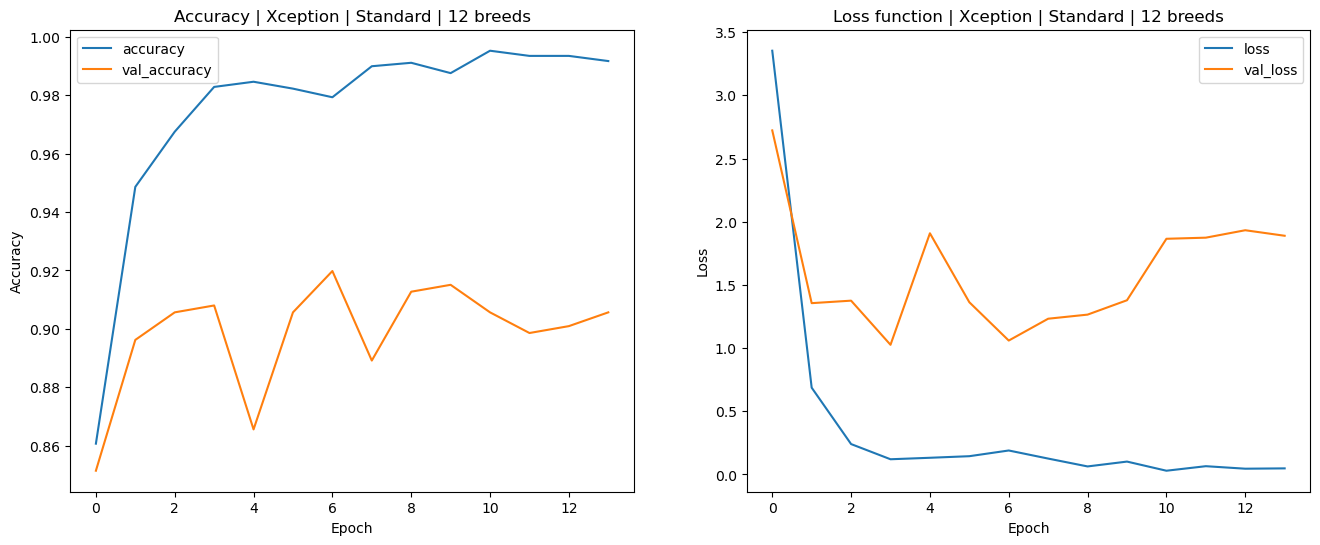

In [7]:
epochs = 40
verbose = 1
early_stopping_monitor = EarlyStopping(patience=10)

model_std = get_model(act_function='relu')
model_std.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

history_std = model_std.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "Standard"
plot_result_fitting(history_std, subtitle, title, n_breeds)


### 3-3-2. Mesure de l'effet Data Augmentation

Epoch 1/40
77/77 [==============================] - 36s 470ms/step - loss: 3.8910 - accuracy: 0.7704 - val_loss: 1.3220 - val_accuracy: 0.8892
Epoch 2/40
77/77 [==============================] - 34s 445ms/step - loss: 1.1144 - accuracy: 0.8577 - val_loss: 0.3711 - val_accuracy: 0.8939
Epoch 3/40
77/77 [==============================] - 36s 468ms/step - loss: 0.4721 - accuracy: 0.8601 - val_loss: 0.3677 - val_accuracy: 0.9080
Epoch 4/40
77/77 [==============================] - 35s 450ms/step - loss: 0.4498 - accuracy: 0.8772 - val_loss: 0.4585 - val_accuracy: 0.8915
Epoch 5/40
77/77 [==============================] - 35s 460ms/step - loss: 0.3993 - accuracy: 0.8725 - val_loss: 0.4440 - val_accuracy: 0.9080
Epoch 6/40
77/77 [==============================] - 36s 462ms/step - loss: 0.4275 - accuracy: 0.8849 - val_loss: 0.3734 - val_accuracy: 0.8986
Epoch 7/40
77/77 [==============================] - 35s 453ms/step - loss: 0.4217 - accuracy: 0.8802 - val_loss: 0.3028 - val_accuracy: 0.9175

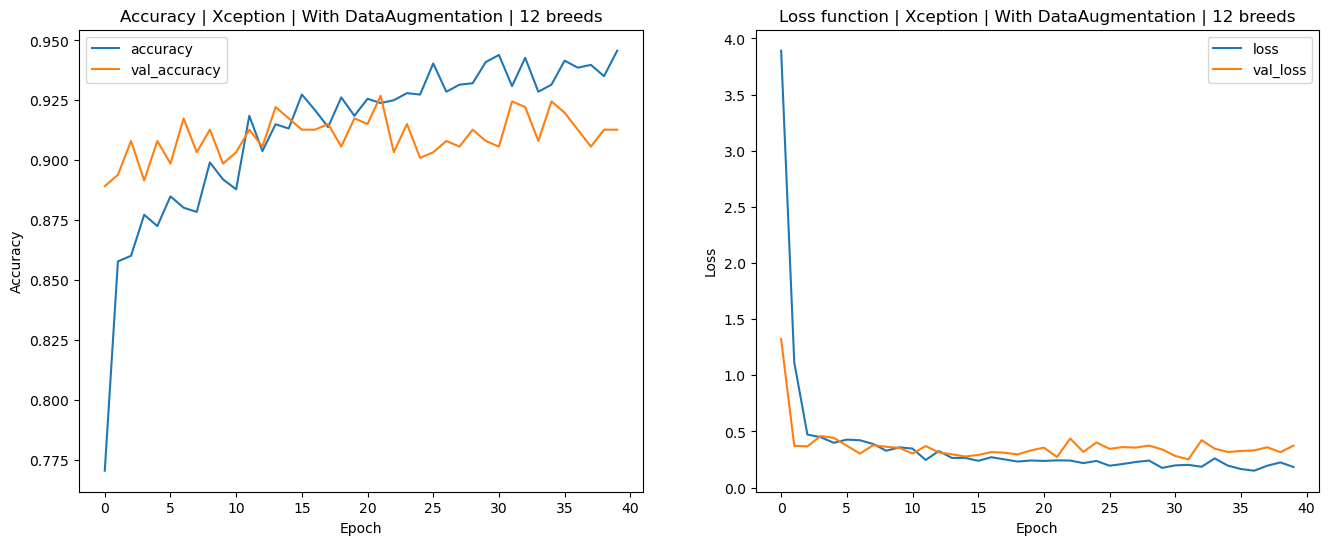

In [8]:
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAugmentation"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

In [10]:
model_modified.evaluate(test_gen)

53/53 [==============================] - 4s 70ms/step - loss: 0.3764 - accuracy: 0.9264


[0.3764486312866211, 0.9264150857925415]

### 3-3-4. Mesure de l'effet Fine Tuning
Pour mesurer cela, je dégèle la dernière couche de l'algorithme pour entraînement.

In [ ]:
for layer in conv_base.layers:
   print(layer.name)

In [ ]:
# Avec fine tuning
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Rappel du nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))

for layer in conv_base.layers[:-24]:
    layer.trainable = False
for layer in conv_base.layers[-24:]:
    layer.trainable = True
        
print('Nombre de poids entraînable après dégel de la dernière couche base convolutionnelle :', len(conv_base.trainable_weights))

# Avec fine tuning
model_modified = get_model(act_function='relu')
model_modified.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
history_modified = model_modified.fit(train_gen_data_aug, validation_data=val_gen, epochs=epochs, verbose=verbose, callbacks = [early_stopping_monitor])

title = "With DataAug & FineTuning"

plot_result_fitting(history_modified, subtitle, title, n_breeds)

### 3-3-5. Conclusion sur les différentes mesures
* La data augmentation augmente les performance du modèle mais le rend légèrement moins stable
* Batch normalization dégrade le modèle
* Dropout avec une valeur de 0.2 maintient le modèle, mais diminue sa stabilité, Dropout avec une valeur de 0.5 dégrade le modèle et le rend instable.
* Contre mon attente, le fine tuning dégrade fortement le modèle, peut-être il y a un problème ?

## 3-4. Evaluation

In [11]:
conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

# Résumé du modèle
model_final.summary()

Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_5 (Dense)              (None, 12)                3084      
Total params: 33,972,020
Trainable params: 13,110,540
Non-trainable params: 20,861,480
_________________________________________________________________


----

In [ ]:
model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])
title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

In [ ]:
model_final.evaluate(test_gen)

# 4. Evaluation du modèle avec 60 races (50 %)

Nous avons 60 races sélectionnées pour la montée en charge.
Found 7286 validated image filenames belonging to 60 classes.
Found 1822 validated image filenames belonging to 60 classes.
Found 2278 validated image filenames belonging to 60 classes.
Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Epoch 1/500
3643/3643 [==============================] - 107s 29ms/step - loss: 2.1656 - accuracy: 0.4327 - val_loss: 1.4314 - val_accuracy: 0.5982
Epoch 2/500
3643/3643 [==============================] - 96s 26ms/step - loss: 1.8077 - accuracy: 0.5063 - val_loss: 1.3378 - val_accuracy: 0.6334
Epoch 3/500
3643/3643 [==============================] - 95s 26ms/step - loss: 1.7142 - accuracy: 0.5305 - val_loss: 1.3697 - val_accuracy: 0.6196
Epoch 4/500
3643/3643 [==============================] - 96s 26ms/step - loss: 1.6972 - accuracy: 0.5384 - val_loss: 1.3661 - val_accuracy: 0.6323
Epoch 5/500
3643/3643 [

[1.5067304372787476, 0.640035092830658]

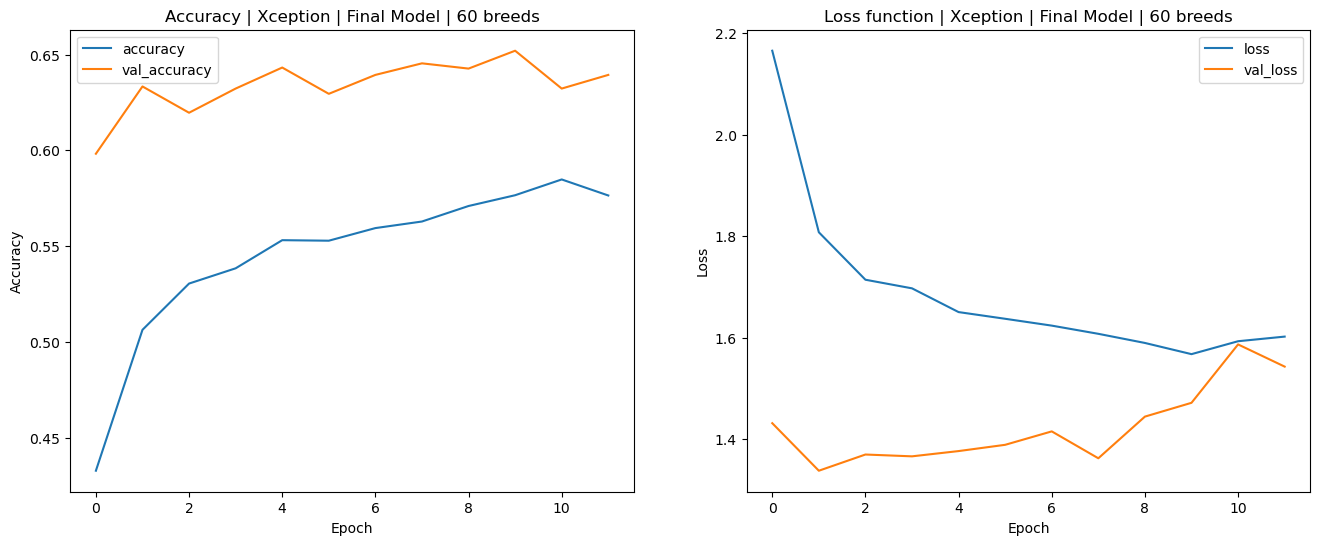

In [12]:
n_breeds = 60
# Création du dataframe avec 50 races
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la montée en charge.")

# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (150, 150)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

conv_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(GlobalAveragePooling2D()) # Remplacement de Flatten() par GlobalAveragePooling2D() pour les fortes volumétrie
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

model_final.evaluate(test_gen)

# 120 races

Nous avons 120 races sélectionnées pour la montée en charge.
Found 13171 validated image filenames belonging to 120 classes.
Found 3293 validated image filenames belonging to 120 classes.
Found 4116 validated image filenames belonging to 120 classes.
Nombre de poids entraînable avant gel de la base convolutionnelle : 154
Nombre de poids entraînable après gel de la base convolutionnelle : 0
Epoch 1/500
13171/13171 [==============================] - 321s 24ms/step - loss: 1.6492 - accuracy: 0.5741 - val_loss: 0.8974 - val_accuracy: 0.7449
Epoch 2/500
13171/13171 [==============================] - 322s 24ms/step - loss: 1.2881 - accuracy: 0.6604 - val_loss: 1.0124 - val_accuracy: 0.7443
Epoch 3/500
13171/13171 [==============================] - 317s 24ms/step - loss: 1.3109 - accuracy: 0.6630 - val_loss: 0.9355 - val_accuracy: 0.7671
Epoch 4/500
13171/13171 [==============================] - 312s 24ms/step - loss: 1.3022 - accuracy: 0.6742 - val_loss: 1.0335 - val_accuracy: 0.7549
Epoch 5

[1.2677658796310425, 0.7502429485321045]

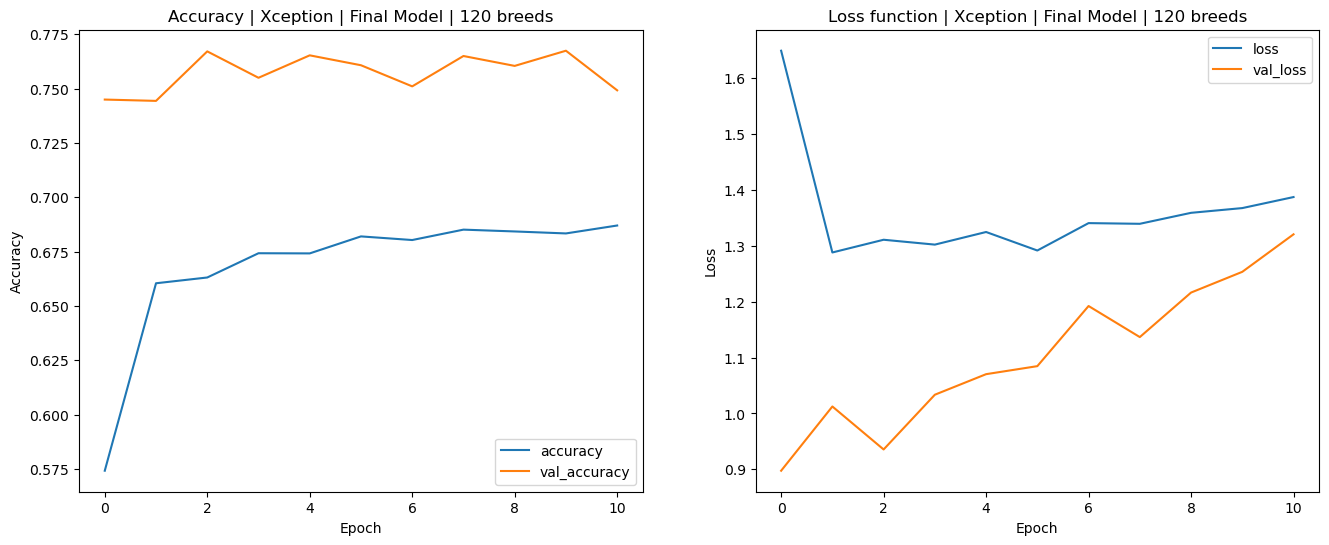

In [14]:
n_breeds = 120
# Création du dataframe avec 50 races
dogs = get_dataframe('../input/stanford-dogs-dataset/images', n_breeds)
print(f"Nous avons {dogs.breeds.nunique()} races sélectionnées pour la montée en charge.")

# Séparation des données d'entrainements et de tests
train, test = train_test_split(dogs, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

### Paramétrage
x = 'uri'
y = 'breeds'
target_size = (256, 256)
seed = 42

train_batch_size = get_batch_size(len(train))
val_batch_size = get_batch_size(len(val))
test_batch_size = get_batch_size(len(test))

train_datagen_aug = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Avec augmentation des données
train_gen_data_aug = train_datagen_aug.flow_from_dataframe(
                          train,
                          x_col='uri',
                          y_col='breeds',
                          target_size=target_size,
                          batch_size=train_batch_size,
                          seed=seed
                          )

val_gen = val_test_datagen.flow_from_dataframe(
                  val,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=val_batch_size,
                  seed=seed
                  )

test_gen = val_test_datagen.flow_from_dataframe(
                  test,
                  x_col = x,
                  y_col = y,
                  target_size=target_size,
                  batch_size=test_batch_size,
                  seed=seed,
                  shuffle=False
                  )

conv_base = Xception(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
print('Nombre de poids entraînable avant gel de la base convolutionnelle :', len(conv_base.trainable_weights))
conv_base.trainable = False
print('Nombre de poids entraînable après gel de la base convolutionnelle :', len(conv_base.trainable_weights))

model_final = Sequential()
model_final.add(conv_base)
model_final.add(GlobalAveragePooling2D()) # Remplacement de Flatten() par GlobalAveragePooling2D() pour les fortes volumétrie
model_final.add(Dense(256, activation='relu'))
model_final.add(Dense(len(train_gen_data_aug.class_indices), activation='softmax'))

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
model_save = ModelCheckpoint('best_model_' + subtitle + '.hdf5', save_best_only=True)

history = model_final.fit(train_gen_data_aug, validation_data=val_gen, epochs=500, callbacks = [early_stopping_monitor, model_save])

title = 'Final Model'
plot_result_fitting(history, subtitle, title, n_breeds)

model_final.evaluate(test_gen)